# Introduction


# Data

In [4]:
GOOGLE_DRIVE = False

In [5]:
# Importing different libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

In [6]:
if GOOGLE_DRIVE:
    # Importing data from google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Importing data from google drive
    df = pd.read_csv("drive/My Drive/dataset/twitter_sentiment/tweet_product_company.csv", 
                     encoding='unicode_escape')
else:
    df = pd.read_csv('tweet.csv', encoding='unicode_escape')

In [7]:
df.columns=['text', 'product', 'target']
df.head()

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
df.shape

(9093, 3)

In [9]:
df['target'].value_counts(1)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

# Round 1: Positive and Negative Emtions Only

In [10]:
df1 = df[(df['target']=='Positive emotion') | (df['target']=='Negative emotion')].copy()

In [11]:
df1['target'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: target, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df1[['text']],
                                                    df1['target'], 
                                                    random_state=42)

In [43]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
np.random.seed(0)

In [15]:
def process_text(tweet,
                 pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                 stopwords_list=stopwords.words('english') + list(string.punctuation)):
    tokens = nltk.regexp_tokenize(tweet, pattern)
    
    # Filters out all the stop words
    tokens_stopped = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return tokens_stopped

In [17]:
processed_tweets = list(map(process_text, X_train['text']))

In [18]:
total_tweets = []
vocab_tweets = set()
for tweet in processed_tweets:
    total_tweets += tweet
    vocab_tweets.update(tweet)
total_tweets_freqdist = FreqDist(total_tweets)
total_tweets_freqdist.most_common(200)

[('sxsw', 2803),
 ('mention', 1856),
 ('ipad', 1081),
 ('link', 988),
 ('rt', 795),
 ('apple', 767),
 ('google', 631),
 ('iphone', 529),
 ('quot', 457),
 ('store', 447),
 ('app', 328),
 ('new', 289),
 ('austin', 250),
 ('android', 173),
 ('pop', 172),
 ('amp', 162),
 ('get', 143),
 ('launch', 137),
 ('time', 118),
 ('social', 116),
 ('circles', 115),
 ('line', 114),
 ('like', 114),
 ('one', 107),
 ('great', 106),
 ('via', 106),
 ('party', 103),
 ('free', 101),
 ('today', 100),
 ("i'm", 99),
 ('day', 98),
 ('cool', 93),
 ('people', 90),
 ('mobile', 89),
 ('maps', 87),
 ('w', 85),
 ('sxswi', 84),
 ('apps', 82),
 ('go', 81),
 ('good', 80),
 ('network', 79),
 ('awesome', 78),
 ('temporary', 75),
 ('going', 68),
 ('love', 68),
 ('got', 67),
 ('opening', 66),
 ('downtown', 66),
 ('see', 65),
 ('even', 62),
 ('check', 61),
 ('around', 58),
 ('need', 58),
 ('mayer', 57),
 ('called', 56),
 ('first', 56),
 ('users', 56),
 ('thanks', 54),
 ('news', 53),
 ('open', 53),
 ('popup', 52),
 ('major', 5

In [19]:
# Total number of tweets
len(vocab_tweets)

4991

In [21]:
vectorizer = TfidfVectorizer()

In [23]:
X_train_tf_idf = vectorizer.fit_transform(X_train['text'])
X_test_tf_idf = vectorizer.transform(X_test['text'])

In [26]:
nb_clf = MultinomialNB()
rf_clf = RandomForestClassifier()

In [27]:
X_train_tf_idf.shape

(2661, 5235)

In [28]:
nb_clf.fit(X_train_tf_idf, y_train)
nb_train_preds = nb_clf.predict(X_train_tf_idf) 
nb_test_preds = nb_clf.predict(X_test_tf_idf) 

In [29]:
rf_clf.fit(X_train_tf_idf, y_train)
rf_train_preds = rf_clf.predict(X_train_tf_idf)
rf_test_preds = rf_clf.predict(X_test_tf_idf)

In [30]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8467 		 Testing Accuracy: 0.8512

----------------------------------------------------------------------

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.876


In [31]:
import src.useful_codes as uc

In [32]:
pd.Series(y_test).value_counts(1)

Positive emotion    0.845547
Negative emotion    0.154453
Name: target, dtype: float64

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.876
                  precision    recall  f1-score   support

Negative emotion       0.89      0.23      0.36       137
Positive emotion       0.88      0.99      0.93       750

        accuracy                           0.88       887
       macro avg       0.88      0.61      0.65       887
    weighted avg       0.88      0.88      0.84       887

------------------------------------------------------------




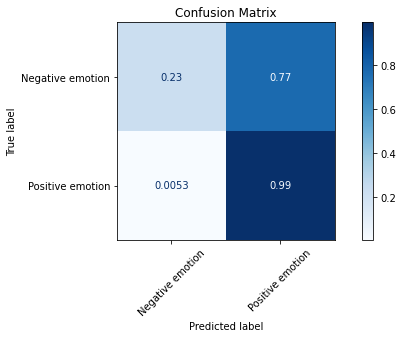

In [37]:
uc.evaluate_clf_model(rf_clf, X_train_tf_idf, y_train, X_test_tf_idf, y_test,
                   classes=['Negative emotion', 'Positive emotion'],
                   label='NB Classifier');

In [34]:
rf_clf_2 = RandomForestClassifier(n_estimators=500,
                                  class_weight='balanced',
                                  max_features='sqrt')
rf_clf_2.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=500)

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.8737
                  precision    recall  f1-score   support

Negative emotion       0.86      0.22      0.35       137
Positive emotion       0.87      0.99      0.93       750

        accuracy                           0.87       887
       macro avg       0.87      0.61      0.64       887
    weighted avg       0.87      0.87      0.84       887

------------------------------------------------------------




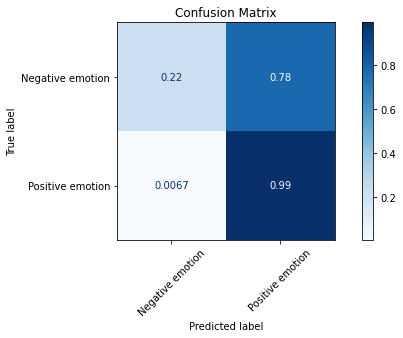

In [38]:
uc.evaluate_clf_model(rf_clf_2, X_train_tf_idf, y_train, X_test_tf_idf, y_test,
                   classes=['Negative emotion', 'Positive emotion'],
                   label='NB Classifier');

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.8467
Test Accuracy :  0.8512
                  precision    recall  f1-score   support

Negative emotion       1.00      0.04      0.07       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.93      0.52      0.49       887
    weighted avg       0.87      0.85      0.79       887

------------------------------------------------------------




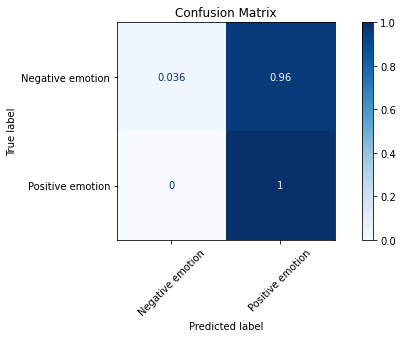

In [39]:
uc.evaluate_clf_model(nb_clf, X_train_tf_idf, y_train, X_test_tf_idf, y_test,
                   classes=['Negative emotion', 'Positive emotion'],
                   label='NB Classifier');